In [1]:
import torch
import torchvision.transforms as transforms
import os
import subprocess
from PIL import Image
from torchvision.transforms.functional import to_tensor
import shutil

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [109]:
# Preprocessing transform
preprocess_frame = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop((700,1244)),
    transforms.CenterCrop((640,640)),


    #transforms.RandomApply(torch.nn.ModuleList([
    #transforms.ColorJitter(),
    #]), p=0.3)
])

preprocess_video = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
])

In [33]:
def show_sequence(sequence, NUM_FRAMES):
    columns = 4
    rows = (NUM_FRAMES + 1) // (columns)
    fig = plt.figure(figsize=(32, (16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        frames = sequence[j].permute(1,2,0).numpy()
        frames = frames/ frames.max()
        plt.imshow(frames)

    plt.show()

In [93]:
def data_and_words(path):
    words = os.listdir(path)
    words_list = []
    data = []
    for word in words:
        words_list.append(word)
        word_videos_path = os.path.join(path, word)
        videos = os.listdir(word_videos_path)
        for video in videos:
            data.append((os.path.join(word_videos_path, video), len(words_list)-1))

    words_dict = dict({})
    for num, word in enumerate(words_list):
        words_dict[word] = num

    return data, words_list, words_dict

In [94]:
train_data, idx_to_word, word_to_idx = data_and_words(r"D:\ISL\Training_dataset")
test_data, idx_to_word, word_to_idx = data_and_words(r"D:\ISL\Testing_dataset")

In [36]:
### Depricated!!!!!!!
'''
from torch.utils.data import Dataset, DataLoader

class VideoDataset(Dataset):
    def __init__(self, data, NUM_FRAMES=10, transform=None):
        self.data = data
        self.transform = transform
        self.NUM_FRAMES = NUM_FRAMES

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_frames, _, _ = read_video(self.data[idx][0], pts_unit="sec")
        video_frames = video_frames.permute(0, 3, 1, 2)
        video_frames = torch.tensor(video_frames, dtype=torch.float32)

        # Setting variables for the range in for loop
        starting_frame = 0
        step_size = len(video_frames)//self.NUM_FRAMES
        ending_frame = len(video_frames)-len(video_frames)%self.NUM_FRAMES  # Subtraction to remove the remainder so that we run the for loop extra

        if self.transform:
            video_frames = torch.stack([self.transform(video_frames[n]) for n in range(starting_frame, ending_frame, step_size)])

        video_frames = video_frames/255.0

        label = self.data[idx][1]
        return video_frames, label
'''

'\nfrom torch.utils.data import Dataset, DataLoader\n\nclass VideoDataset(Dataset):\n    def __init__(self, data, NUM_FRAMES=10, transform=None):\n        self.data = data\n        self.transform = transform\n        self.NUM_FRAMES = NUM_FRAMES\n\n    def __len__(self):\n        return len(self.data)\n\n    def __getitem__(self, idx):\n        video_frames, _, _ = read_video(self.data[idx][0], pts_unit="sec")\n        video_frames = video_frames.permute(0, 3, 1, 2)\n        video_frames = torch.tensor(video_frames, dtype=torch.float32)\n\n        # Setting variables for the range in for loop\n        starting_frame = 0\n        step_size = len(video_frames)//self.NUM_FRAMES\n        ending_frame = len(video_frames)-len(video_frames)%self.NUM_FRAMES  # Subtraction to remove the remainder so that we run the for loop extra\n\n        if self.transform:\n            video_frames = torch.stack([self.transform(video_frames[n]) for n in range(starting_frame, ending_frame, step_size)])\n\n   

In [105]:
from torch.utils.data import Dataset, DataLoader

class VideoDataset(Dataset):
    def __init__(self, data, temp_data_folder, NUM_FRAMES=10, transform_frame=None,transform_video=None, video_fps=25, resolution='1920:1080'):
        self.data = data  # It should be a list of tuples where data[0] is the path to the video and data[1] is the label

        self.transform_frame = transform_frame  # transformations to be done on the video.
                                    # Note: If the Dataset is showing tensor issue, try adding `ToTensor()` in transform.

        self.transform_video = transform_video

        self.NUM_FRAMES = NUM_FRAMES  # Number of frames to be extracted from the video

        self.fps = video_fps  # The fps at which the video will be saved by ffmpeg
                              # Note: Reducing this might give a small performance increase, which might add up when running it multiple times. But this will also lead to
                              # loss of some data, as some frames will be dropped by ffmpeg

        self.resolution = resolution  # resolution at which ffmpeg will save the frames (could be the same as the video or different).
                                      # Note: Reducing this might give a small performance increase, which might add up when running it multiple times.

        self.temp_data_folder = temp_data_folder  # A temp folder where ffmpeg can store the frames of the video
                                                  # NOTE: this folder is recommended to be empty as frames get deleted from the folder after they are loaded as tensor!!


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        video_path = self.data[idx][0]
        video_file_name = os.path.basename(video_path)
        output_video_path = os.path.join(self.temp_data_folder, video_file_name)  # creating a temp path in the temp_folder for saaving the frames of the video
        os.makedirs(output_video_path, exist_ok=True)

        # Command to convert the video to frames
        fallback_cmd = [
                    'ffmpeg',
                    '-i', video_path,
                    '-vf', f'fps={self.fps},scale={self.resolution},format=yuv420p',
                    '-q:v', '2',
                    os.path.join(output_video_path, 'img_%05d.jpg')
        ]
        subprocess.run(fallback_cmd, check=True, stderr=subprocess.PIPE)

        video_frames = []

        video_images = os.listdir(output_video_path)

        # Setting variables for the range in for loop
        starting_frame = 0
        step_size = len(video_images)//self.NUM_FRAMES
        ending_frame = len(video_images)-len(video_images)%self.NUM_FRAMES  # Subtraction to remove the remainder so that we run the for loop extra

        # Selecting the NUM_FRAMES from the video
        for n in range(starting_frame, ending_frame, step_size):
            img = video_images[n]
            img_path = os.path.join(output_video_path, img)
            with Image.open(img_path) as pil_img:
                if self.transform_frame:
                    video_frames.append(self.transform_frame(pil_img))  # Try adding ToTensor() in transform, if any tensor related error arrises.
                else:
                    video_frames.append(to_tensor(pil_img))

        video_frames = torch.stack(video_frames)
        if self.transform_video:
            video_frames = self.transform_video(video_frames)
        shutil.rmtree(output_video_path)

        label = self.data[idx][1]
        return video_frames, label

In [121]:
train_dataset = VideoDataset(data=train_data, temp_data_folder=r"D:\ISL_temp", transform_frame=preprocess_frames, transform_video=preprocess_video,
                             NUM_FRAMES=12, video_fps=12, resolution='1366:768')

train_dataloader = DataLoader(train_dataset, batch_size=24, shuffle=True)


test_dataset = VideoDataset(data=test_data, temp_data_folder=r"D:\ISL_temp", transform_frame=preprocess_frames, transform_video=preprocess_video,
                            NUM_FRAMES=12, video_fps=12, resolution='1366:768')

test_dataloader = DataLoader(test_dataset, batch_size=24, shuffle=True)

In [122]:
vid, label = next(iter(train_dataloader))

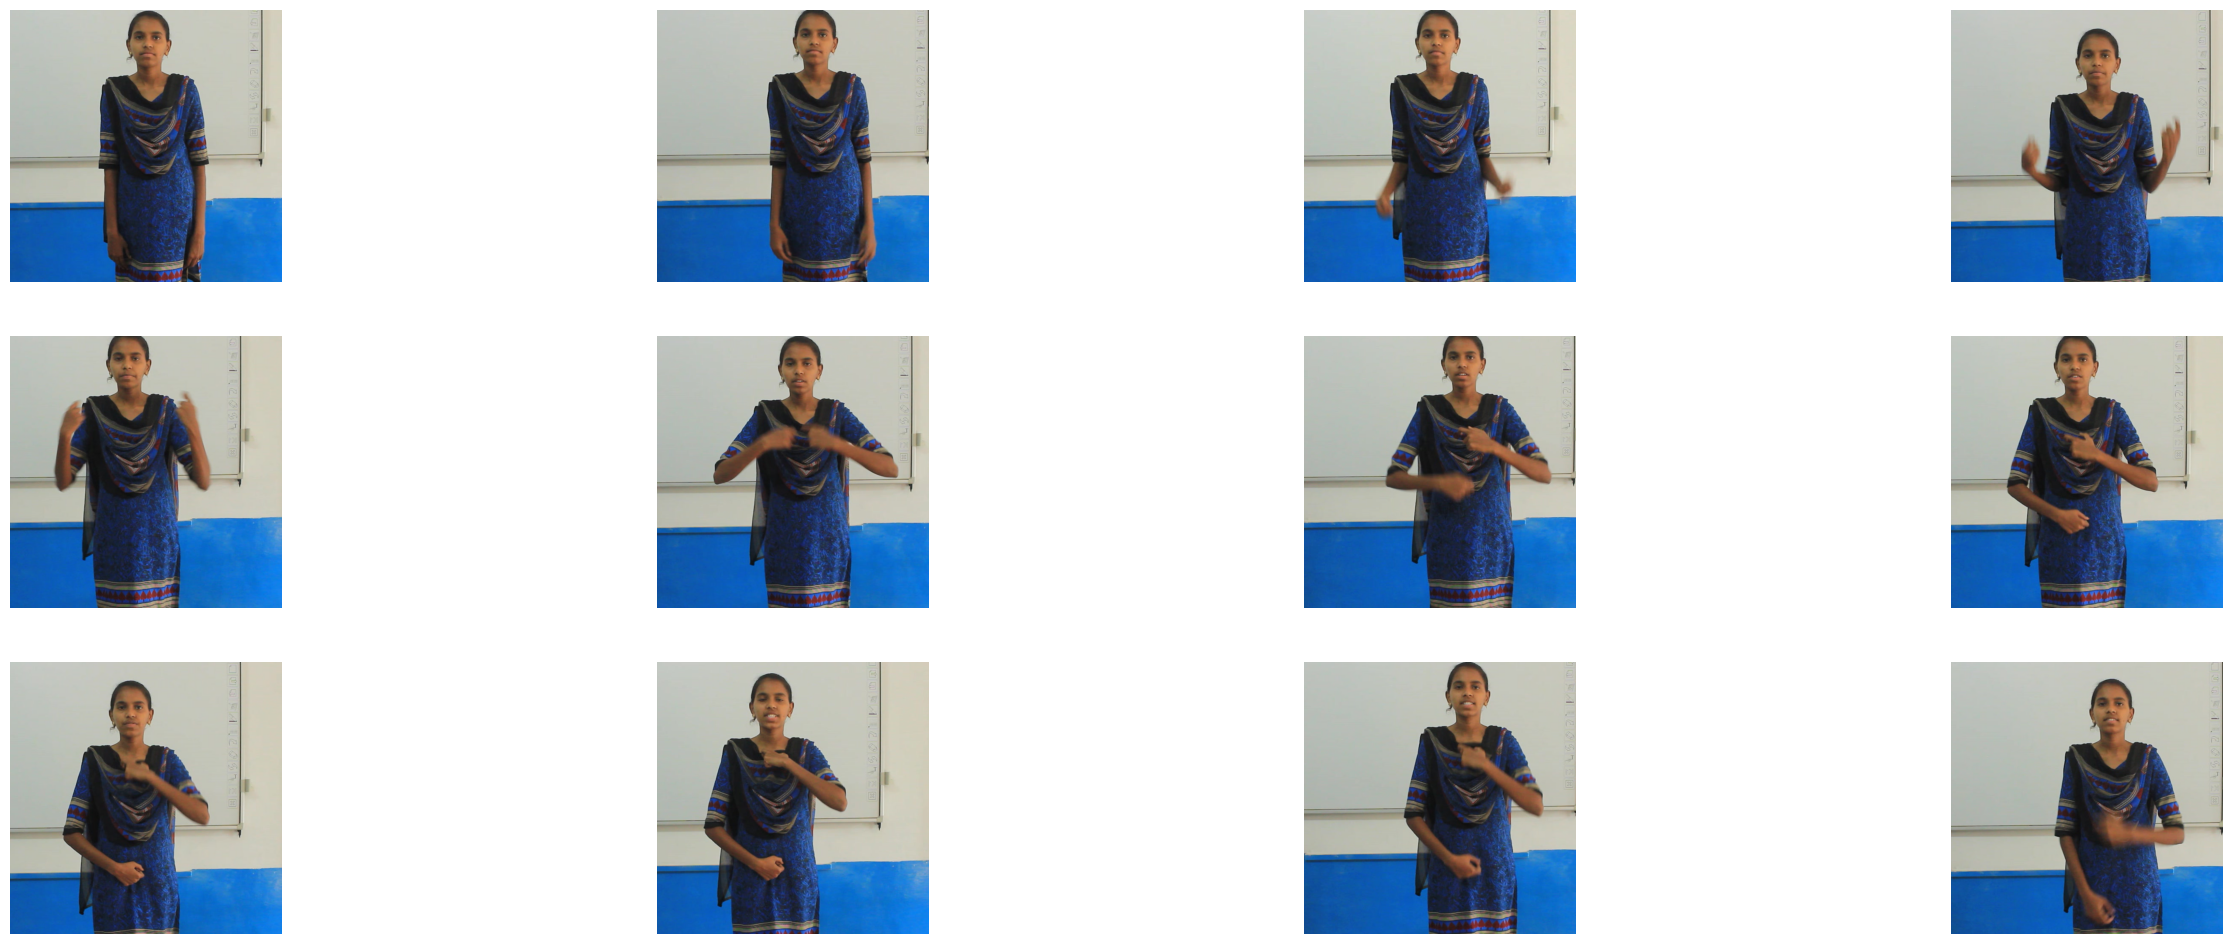

In [123]:
show_sequence(vid[2], 12)

In [126]:
idx_to_word[label[2]]

'suit'

In [127]:
vid.shape

torch.Size([24, 12, 3, 640, 640])